In [5]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   -------------------------------


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
!pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - ----------------------------

In [47]:
# Cell 1: Imports & config

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, r2_score

plt.style.use("ggplot")
pd.set_option("display.max_columns", 80)


BASE_DIR = "../Model_Data"

DATA_CONFIG = {
    "fruit": {
        "X_path": os.path.join(BASE_DIR, "fruit_X.csv"),
        "y_path": os.path.join(BASE_DIR, "fruit_y.csv"),
        "clean_path": "../Data_preprocessing/fruit_sales_clean.csv",
    },
    "veg": {
        "X_path": os.path.join(BASE_DIR, "veg_X.csv"),
        "y_path": os.path.join(BASE_DIR, "veg_y.csv"),
        "clean_path": "../Data_preprocessing/vegetable_sales_clean.csv",
    },
}

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)


In [48]:
DATA_CONFIG

{'fruit': {'X_path': '../Model_Data\\fruit_X.csv',
  'y_path': '../Model_Data\\fruit_y.csv',
  'clean_path': '../Data_preprocessing/fruit_sales_clean.csv'},
 'veg': {'X_path': '../Model_Data\\veg_X.csv',
  'y_path': '../Model_Data\\veg_y.csv',
  'clean_path': '../Data_preprocessing/vegetable_sales_clean.csv'}}

In [49]:
# Cell 2: helper to load dataset

def load_dataset(kind: str):
    """
    Load:
      - X: encoded + scaled features
      - y: target quantity_sold
      - df_clean: cleaned dataframe for date/item & TS stuff
    """
    cfg = DATA_CONFIG[kind]

    X = pd.read_csv(cfg["X_path"])
    y = pd.read_csv(cfg["y_path"], header=None).iloc[:, 0]
    df_clean = pd.read_csv(cfg["clean_path"])
    df_clean["date"] = pd.to_datetime(df_clean["date"])

    assert len(X) == len(y) == len(df_clean), "Length mismatch between X, y, clean data"

    # Attach item + date as helper columns on X (for time-based split)
    X["item"] = df_clean["item"].values
    X["date"] = df_clean["date"].values

    return X, y, df_clean

fruit_X, fruit_y, fruit_df = load_dataset("fruit")
veg_X, veg_y, veg_df = load_dataset("veg")

print("Fruit:", fruit_X.shape, fruit_y.shape, fruit_df.shape)
print("Veg:", veg_X.shape, veg_y.shape, veg_df.shape)
fruit_df.head()


Fruit: (589, 18) (589,) (589, 13)
Veg: (1161, 23) (1161,) (1161, 13)


,date,item,quantity_sold,price,is_event_raw,is_weekend_raw,weather_raw,is_event,day_of_week,is_weekend,weather,month,season
0,2025-08-03,Apple,21,142,No,Yes,Sunny,0,6,1,Sunny,8,Rainy
1,2025-08-03,Banana,70,38,No,Yes,Sunny,0,6,1,Sunny,8,Rainy
2,2025-08-03,Mango,14,97,No,Yes,NaN,0,6,1,Sunny,8,Rainy
3,2025-08-03,Orange,29,58,No,Yes,Sunny,0,6,1,Sunny,8,Rainy
4,2025-08-04,Apple,21,138,No,No,Sunny,0,0,0,Sunny,8,Rainy


In [50]:
#quick summary stats/EDA
def quick_summary(df: pd.DataFrame, title: str):
    print(f"\n==== {title} ====")
    print("Shape:", df.shape)
    print("\nItems:")
    print(df["item"].value_counts())
    print("\nSeasons:")
    print(df["season"].value_counts())
    print("\nWeather:")
    print(df["weather"].value_counts())

quick_summary(fruit_df, "FRUIT DATA SUMMARY")
quick_summary(veg_df, "VEG DATA SUMMARY")



==== FRUIT DATA SUMMARY ====
Shape: (589, 13)

Items:
item
Banana    119
Apple     118
Grapes    118
Mango     117
Orange    117
Name: count, dtype: int64

Seasons:
season
Rainy         290
Transition    150
Winter        149
Name: count, dtype: int64

Weather:
weather
Sunny     423
Cloudy    132
Rain       34
Name: count, dtype: int64

==== VEG DATA SUMMARY ====
Shape: (1161, 13)

Items:
item
Brinjal        120
Cauliflower    119
Cabbage        118
LadyFinger     117
Potato         117
GreenChilli    116
Tomato         115
Onion          114
Capsicum       113
Spinach        112
Name: count, dtype: int64

Seasons:
season
Rainy         569
Transition    299
Winter        293
Name: count, dtype: int64

Weather:
weather
Sunny     767
Cloudy    228
Rain      166
Name: count, dtype: int64


In [51]:
# Cell 3: Moving Average (item-wise time-series baseline)

def moving_average_itemwise(df_clean: pd.DataFrame, kind: str, window: int = 7, test_ratio: float = 0.2):
    """
    Simple time-series baseline:
      For each item:
        - sort by date
        - last `test_ratio` fraction used as test
        - prediction = rolling mean over previous `window` days
    """
    print(f"\n===== ⏳ Moving Average Baseline ({kind}) =====")

    df = df_clean.copy().sort_values(["item", "date"])

    maes = []
    rows = []

    for item in sorted(df["item"].unique()):
        item_df = df[df["item"] == item].copy().sort_values("date")
        n = len(item_df)
        if n < window + 5:
            print(f"  ⚠ Skipping {item}: not enough history ({n} rows)")
            continue

        split_idx = int((1 - test_ratio) * n)
        test_df = item_df.iloc[split_idx:]

        item_df["ma_window"] = item_df["quantity_sold"].rolling(window=window, min_periods=1).mean()

        y_true = test_df["quantity_sold"]
        y_pred = item_df["ma_window"].iloc[split_idx:]

        mae = mean_absolute_error(y_true, y_pred)
        maes.append(mae)

        rows.append({"kind": kind, "item": item, "model": "MovingAverage_itemwise", "mae": mae, "r2": np.nan})

        print(f"  {item}: MAE={mae:.3f} (n_test={len(y_true)})")

    print(f"\n👉 {kind} Moving Average mean MAE: {np.mean(maes):.3f}")
    return pd.DataFrame(rows)

ma_fruit = moving_average_itemwise(fruit_df, "fruit", window=7)
ma_veg   = moving_average_itemwise(veg_df,   "veg",   window=7)

pd.concat([ma_fruit, ma_veg], ignore_index=True)



===== ⏳ Moving Average Baseline (fruit) =====
  Apple: MAE=4.685 (n_test=24)
  Banana: MAE=8.833 (n_test=24)
  Grapes: MAE=8.417 (n_test=24)
  Mango: MAE=4.667 (n_test=24)
  Orange: MAE=7.411 (n_test=24)

👉 fruit Moving Average mean MAE: 6.802

===== ⏳ Moving Average Baseline (veg) =====
  Brinjal: MAE=4.839 (n_test=24)
  Cabbage: MAE=4.167 (n_test=24)
  Capsicum: MAE=4.317 (n_test=23)
  Cauliflower: MAE=5.845 (n_test=24)
  GreenChilli: MAE=3.065 (n_test=24)
  LadyFinger: MAE=5.542 (n_test=24)
  Onion: MAE=11.398 (n_test=23)
  Potato: MAE=11.232 (n_test=24)
  Spinach: MAE=9.720 (n_test=23)
  Tomato: MAE=5.342 (n_test=23)

👉 veg Moving Average mean MAE: 6.547


,kind,item,model,mae,r2
0,fruit,Apple,MovingAverage_itemwise,4.684524,NaN
1,fruit,Banana,MovingAverage_itemwise,8.833333,NaN
2,fruit,Grapes,MovingAverage_itemwise,8.416667,NaN
3,fruit,Mango,MovingAverage_itemwise,4.666667,NaN
4,fruit,Orange,MovingAverage_itemwise,7.410714,NaN
5,veg,Brinjal,MovingAverage_itemwise,4.839286,NaN
6,veg,Cabbage,MovingAverage_itemwise,4.166667,NaN
7,veg,Capsicum,MovingAverage_itemwise,4.316770,NaN
8,veg,Cauliflower,MovingAverage_itemwise,5.845238,NaN
9,veg,GreenChilli,MovingAverage_itemwise,3.065476,NaN


In [52]:
# Cell 4: Global models (Linear Regression & Random Forest)
def global_models(X: pd.DataFrame, y: pd.Series, kind: str):
    """
    Train + evaluate non-item-wise models:
      - Linear Regression
      - Random Forest
    Time-based split (80/20) on date.
    """
    print(f"\n===== 🌍 Global Models ({kind}) =====")

    X_sorted = X.sort_values("date")
    y_sorted = y.loc[X_sorted.index]

    X_features = X_sorted.drop(columns=["item", "date"])

    n = len(X_features)
    split_idx = int(0.8 * n)
    X_train, X_test = X_features.iloc[:split_idx], X_features.iloc[split_idx:]
    y_train, y_test = y_sorted.iloc[:split_idx], y_sorted.iloc[split_idx:]

    rows = []

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    print(f"  LinearRegression → MAE={mae_lr:.3f}, R²={r2_lr:.3f}")
    rows.append({"kind": kind, "item": None, "model": "Global_LinearRegression", "mae": mae_lr, "r2": r2_lr})

    # Random Forest
    rf = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    print(f"  RandomForest     → MAE={mae_rf:.3f}, R²={r2_rf:.3f}")
    rows.append({"kind": kind, "item": None, "model": "Global_RandomForest", "mae": mae_rf, "r2": r2_rf})

    return pd.DataFrame(rows), lr, rf

global_fruit_df, fruit_lr, fruit_rf = global_models(fruit_X.copy(), fruit_y, "fruit")
global_veg_df,   veg_lr,   veg_rf   = global_models(veg_X.copy(),   veg_y,   "veg")

pd.concat([global_fruit_df, global_veg_df], ignore_index=True)




===== 🌍 Global Models (fruit) =====
  LinearRegression → MAE=4.430, R²=0.610
  RandomForest     → MAE=5.084, R²=0.564

===== 🌍 Global Models (veg) =====
  LinearRegression → MAE=9.621, R²=0.614
  RandomForest     → MAE=6.746, R²=0.656


,kind,item,model,mae,r2
0,fruit,None,Global_LinearRegression,4.429866,0.610314
1,fruit,None,Global_RandomForest,5.083599,0.563577
2,veg,None,Global_LinearRegression,9.621059,0.614208
3,veg,None,Global_RandomForest,6.746040,0.655868


In [53]:
# Cell 5: Item-wise Linear Regression (one model per item)

def itemwise_linear_regression(X: pd.DataFrame, y: pd.Series, kind: str):
    """
    Train a separate Linear Regression model for each item.
    Time-based split within each item.
    """
    print(f"\n===== 🧺 Item-wise Linear Regression ({kind}) =====")

    models = {}
    rows = []

    for item in sorted(X["item"].unique()):
        X_item = X[X["item"] == item].copy().sort_values("date")
        y_item = y.loc[X_item.index]

        X_features = X_item.drop(columns=["item", "date"])
        n = len(X_features)
        if n < 20:
            print(f"  ⚠ Skipping {item}: not enough data ({n}).")
            continue

        split_idx = int(0.8 * n)
        X_train, X_test = X_features.iloc[:split_idx], X_features.iloc[split_idx:]
        y_train, y_test = y_item.iloc[:split_idx], y_item.iloc[split_idx:]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        rows.append({"kind": kind, "item": item, "model": "Item_LR", "mae": mae, "r2": r2})
        models[item] = model

        print(f"  {item} → MAE={mae:.3f}, R²={r2:.3f}")

    return pd.DataFrame(rows), models

item_lr_fruit_df, fruit_item_models = itemwise_linear_regression(fruit_X.copy(), fruit_y, "fruit")
item_lr_veg_df,   veg_item_models   = itemwise_linear_regression(veg_X.copy(),   veg_y,   "veg")

pd.concat([item_lr_fruit_df, item_lr_veg_df], ignore_index=True)



===== 🧺 Item-wise Linear Regression (fruit) =====
  Apple → MAE=3.854, R²=0.575
  Banana → MAE=6.850, R²=0.439
  Grapes → MAE=6.355, R²=0.099
  Mango → MAE=3.693, R²=0.414
  Orange → MAE=3.168, R²=0.740

===== 🧺 Item-wise Linear Regression (veg) =====
  Brinjal → MAE=4.585, R²=0.366
  Cabbage → MAE=3.142, R²=0.508
  Capsicum → MAE=3.890, R²=0.126
  Cauliflower → MAE=4.063, R²=0.516
  GreenChilli → MAE=4.768, R²=-1.009
  LadyFinger → MAE=3.159, R²=0.420
  Onion → MAE=9.032, R²=-0.007
  Potato → MAE=6.837, R²=0.276
  Spinach → MAE=7.159, R²=0.126
  Tomato → MAE=3.090, R²=0.744


,kind,item,model,mae,r2
0,fruit,Apple,Item_LR,3.854212,0.575312
1,fruit,Banana,Item_LR,6.849796,0.438711
2,fruit,Grapes,Item_LR,6.354842,0.099039
3,fruit,Mango,Item_LR,3.693250,0.414382
4,fruit,Orange,Item_LR,3.168190,0.739935
5,veg,Brinjal,Item_LR,4.585465,0.366134
6,veg,Cabbage,Item_LR,3.142156,0.508020
7,veg,Capsicum,Item_LR,3.889518,0.125677
8,veg,Cauliflower,Item_LR,4.062819,0.516205
9,veg,GreenChilli,Item_LR,4.768028,-1.008629


In [ ]:
#Combine all results
all_reg_metrics = pd.concat(
    [
        ma_fruit,
        ma_veg,
        global_fruit_df,
        global_veg_df,
        item_lr_fruit_df,
        item_lr_veg_df,
    ],
    ignore_index=True
)

all_reg_metrics


,kind,item,model,mae,r2
0,fruit,Apple,MovingAverage_itemwise,4.684524,NaN
1,fruit,Banana,MovingAverage_itemwise,8.833333,NaN
2,fruit,Grapes,MovingAverage_itemwise,8.416667,NaN
3,fruit,Mango,MovingAverage_itemwise,4.666667,NaN
4,fruit,Orange,MovingAverage_itemwise,7.410714,NaN
5,veg,Brinjal,MovingAverage_itemwise,4.839286,NaN
6,veg,Cabbage,MovingAverage_itemwise,4.166667,NaN
7,veg,Capsicum,MovingAverage_itemwise,4.316770,NaN
8,veg,Cauliflower,MovingAverage_itemwise,5.845238,NaN
9,veg,GreenChilli,MovingAverage_itemwise,3.065476,NaN


[FRUIT] Apple – Train size: 111, Test size: 7
MAE (last 7 days): 5.361


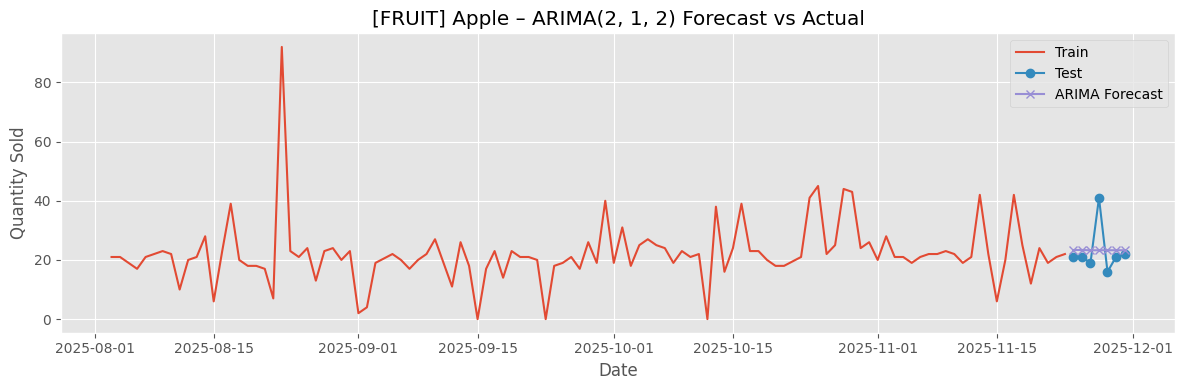

[VEG] Onion – Train size: 107, Test size: 7
MAE (last 7 days): 14.335


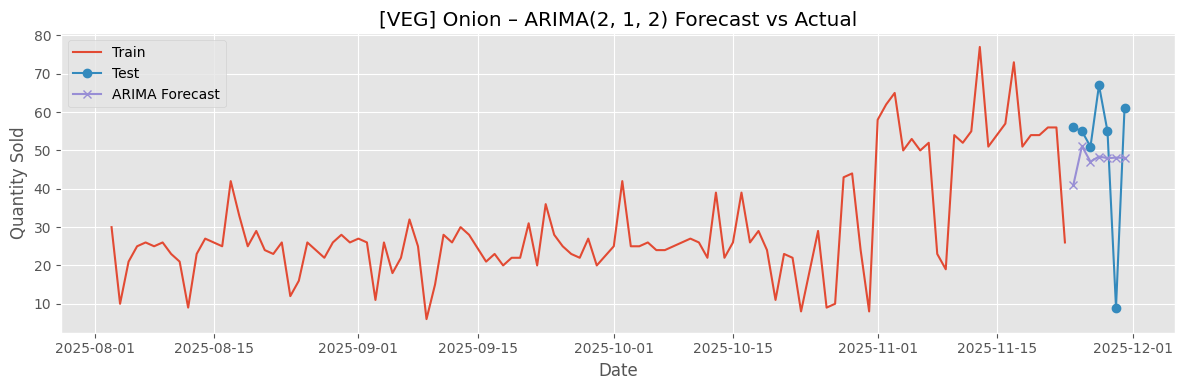

In [56]:
# Cell 8 – Time-Series ARIMA on a Single Item (Visual)

def arima_one_item(df: pd.DataFrame, item: str, horizon: int = 7, order=(2,1,2), title_prefix: str = ""):
    item_df = df[df["item"] == item].copy().sort_values("date")
    y = item_df["quantity_sold"].values
    
    if len(y) <= horizon + 5:
        print(f"⚠ Not enough data for ARIMA on {item}. Need > {horizon+5}, have {len(y)}.")
        return
    
    train, test = y[:-horizon], y[-horizon:]
    dates = item_df["date"].values
    train_dates, test_dates = dates[:-horizon], dates[-horizon:]
    
    print(f"{title_prefix} {item} – Train size: {len(train)}, Test size: {len(test)}")
    
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=horizon)
    
    mae = mean_absolute_error(test, forecast)
    print(f"MAE (last {horizon} days): {mae:.3f}")
    
    # Plot
    plt.figure(figsize=(12, 4))
    plt.plot(train_dates, train, label="Train")
    plt.plot(test_dates, test, label="Test", marker="o")
    plt.plot(test_dates, forecast, label="ARIMA Forecast", marker="x")
    plt.title(f"{title_prefix} {item} – ARIMA{order} Forecast vs Actual")
    plt.xlabel("Date")
    plt.ylabel("Quantity Sold")
    plt.legend()
    plt.tight_layout()
    plt.show()

arima_one_item(fruit_df, "Apple", horizon=7, order=(2,1,2), title_prefix="[FRUIT]")
arima_one_item(veg_df, "Onion", horizon=7, order=(2,1,2), title_prefix="[VEG]")


In [57]:
# Cell 9 – Time-Series ARIMA Item-wise Metrics
def arima_itemwise_metrics(df: pd.DataFrame, kind: str, horizon: int = 7, order=(2,1,2)):
    print(f"\n===== ⏱ ARIMA Item-wise ({kind}) =====")
    rows = []
    
    for item in sorted(df["item"].unique()):
        item_df = df[df["item"] == item].copy().sort_values("date")
        y = item_df["quantity_sold"].values
        
        if len(y) <= horizon + 5:
            print(f"  ⚠ Skipping {kind} – {item}: not enough data ({len(y)})")
            continue
        
        train, test = y[:-horizon], y[-horizon:]
        
        try:
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=horizon)
            mae = mean_absolute_error(test, forecast)
            
            print(f"  {kind.upper()} – {item}: MAE={mae:.3f}")
            rows.append({
                "kind": kind,
                "item": item,
                "model": f"ARIMA{order}",
                "mae": mae,
                "r2": np.nan,
                "horizon": horizon,
                "n_total": len(y),
                "n_test": len(test),
            })
        except Exception as e:
            print(f"  ⚠ ARIMA failed for {kind} – {item}: {e}")
    
    return pd.DataFrame(rows)

arima_fruit_df = arima_itemwise_metrics(fruit_df, "fruit", horizon=7, order=(2,1,2))
arima_veg_df   = arima_itemwise_metrics(veg_df,   "veg",   horizon=7, order=(2,1,2))

all_arima_metrics = pd.concat([arima_fruit_df, arima_veg_df], ignore_index=True)
all_arima_metrics



===== ⏱ ARIMA Item-wise (fruit) =====
  FRUIT – Apple: MAE=5.361
  FRUIT – Banana: MAE=10.461
  FRUIT – Grapes: MAE=11.552


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  FRUIT – Mango: MAE=5.344
  FRUIT – Orange: MAE=9.383

===== ⏱ ARIMA Item-wise (veg) =====
  VEG – Brinjal: MAE=5.610
  VEG – Cabbage: MAE=1.993
  VEG – Capsicum: MAE=4.262
  VEG – Cauliflower: MAE=3.779
  VEG – GreenChilli: MAE=2.944
  VEG – LadyFinger: MAE=4.094
  VEG – Onion: MAE=14.335
  VEG – Potato: MAE=14.342
  VEG – Spinach: MAE=7.712


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  VEG – Tomato: MAE=4.607


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,kind,item,model,mae,r2,horizon,n_total,n_test
0,fruit,Apple,"ARIMA(2, 1, 2)",5.361360,NaN,7,118,7
1,fruit,Banana,"ARIMA(2, 1, 2)",10.461455,NaN,7,119,7
2,fruit,Grapes,"ARIMA(2, 1, 2)",11.551605,NaN,7,118,7
3,fruit,Mango,"ARIMA(2, 1, 2)",5.343744,NaN,7,117,7
4,fruit,Orange,"ARIMA(2, 1, 2)",9.383319,NaN,7,117,7
5,veg,Brinjal,"ARIMA(2, 1, 2)",5.609834,NaN,7,120,7
6,veg,Cabbage,"ARIMA(2, 1, 2)",1.992812,NaN,7,118,7
7,veg,Capsicum,"ARIMA(2, 1, 2)",4.261697,NaN,7,113,7
8,veg,Cauliflower,"ARIMA(2, 1, 2)",3.779111,NaN,7,119,7
9,veg,GreenChilli,"ARIMA(2, 1, 2)",2.943740,NaN,7,116,7
